<a href="https://colab.research.google.com/github/pszemraj/ml4hc-s22-project01/blob/sync-notebooks/notebooks/colab/MITBIH_biGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MITBIH Dataset


In this notebook we trained various more or less complex models on the MITBIH dataset, made predictions and estimated their performance based on the accuracy and f1 score metrics 

## setup

In [ ]:
!nvidia-smi

Sat Mar 26 21:02:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@markdown add auto-Colab formatting with `IPython.display`
from IPython.display import HTML, display
# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )

get_ipython().events.register("pre_run_cell", set_css)

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow.keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,concatenate,Flatten,\
Dense,Dropout,LSTM,Masking,Bidirectional,Dropout,GRU,SimpleRNN,TimeDistributed, BatchNormalization, Activation, MaxPooling1D, GlobalMaxPooling1D, Conv1D
from keras.models import Sequential,Model
import h5py
from sklearn.metrics import f1_score,accuracy_score, roc_auc_score, average_precision_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import collections


In [ ]:
#@title mount drive
from pathlib import Path
from google.colab import drive

drive_base_str = '/content/drive'
drive.mount(drive_base_str)


Mounted at /content/drive


In [ ]:
#@markdown determine root
import os
from pathlib import Path
peter_base = Path('/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/')

if peter_base.exists() and peter_base.is_dir():
    path = str(peter_base.resolve())
else:
    # original
    path = '/content/drive/MyDrive/ETH/'

print(f"base drive dir is:\n{path}")

base drive dir is:
/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1


### define folder for outputs

In [ ]:
_out_dir_name = "MITBIH_biGRU-outputs" #@param {type:"string"}

output_path = os.path.join(path, _out_dir_name)
os.makedirs(output_path, exist_ok=True)
print(f"notebook outputs will be stored in:\n{output_path}")

notebook outputs will be stored in:
/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/MITBIH_biGRU-outputs


###load data

In [ ]:
def load_mitbih(base_path):
    df_train = pd.read_csv(os.path.join(base_path,"data/mitbih_train.csv"),
                           header=None)
    df_train = df_train.sample(frac=1)
    df_test = pd.read_csv(os.path.join(base_path,"data/mitbih_test.csv"),
                          header=None)

    Y = np.array(df_train[187].values).astype(np.int8)
    X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

    Y_test = np.array(df_test[187].values).astype(np.int8)
    X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    return X, X_test, Y, Y_test

In [ ]:
backup_peter = '/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/project-handouts/'

In [ ]:
try:
    X, X_test, Y, Y_test = load_mitbih(base_path=path)
except Exception as e:
    print(f"unable to load data from base path in drive folder because:\n\t{e}")
    print(f"\ngoing to try backup:\n\t{backup_peter}")
    X, X_test, Y, Y_test = load_mitbih(base_path=backup_peter)


## Exploratory Data Analysis

In [ ]:
frequencies=collections.Counter(Y)
for label,frequency in sorted(frequencies.items()):
  print("Class %i contains %i items and consists of %0.2f%s of the data"%(label,frequency,frequency/len(Y)*100,'%'))

Class 0 contains 72471 items and consists of 82.77% of the data
Class 1 contains 2223 items and consists of 2.54% of the data
Class 2 contains 5788 items and consists of 6.61% of the data
Class 3 contains 641 items and consists of 0.73% of the data
Class 4 contains 6431 items and consists of 7.35% of the data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


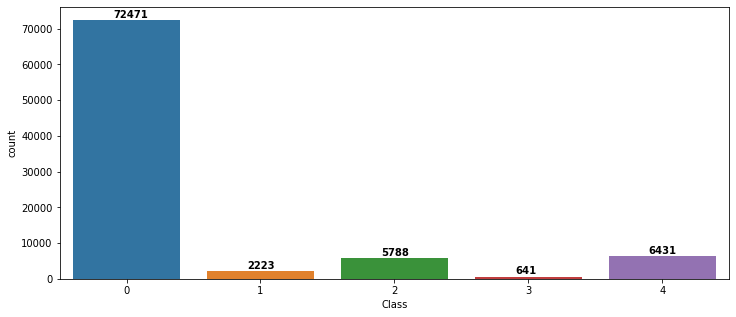

In [ ]:
plt.figure(figsize=(12,5))
ax=sns.countplot(Y)
ax.set_xlabel("Class")
for line in range(5):
     ax.text(line-0.1, frequencies[line]+700,s=str(frequencies[line]), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

We can see that the dataset is higly imbalance between class 0 (healthy controls) and the other minority classes.

---


## Simple models

We implemented the CNN baseline model, another simpler CNN model and a simple RNN

### CNN BASELINE 

In [ ]:
def get_CNN_baseline_model():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model


In [ ]:
model = get_CNN_baseline_model()
file_path = os.path.join(output_path,"baseline_cnn_mitbih.h5")
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

#model.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path) # TODO: wtf is this?

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 183, 16)           96        
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 16)           1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 16)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 16)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 87, 32)            1568      
                                                             

OSError: ignored

### CNN

In [ ]:
CNN_model = Sequential()
CNN_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(187,1)))
CNN_model.add(Conv1D(32, kernel_size=3, activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(5, activation='softmax'))

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 185, 64)           256       
                                                                 
 conv1d_9 (Conv1D)           (None, 183, 32)           6176      
                                                                 
 flatten (Flatten)           (None, 5856)              0         
                                                                 
 dense (Dense)               (None, 5)                 29285     
                                                                 
Total params: 35,717
Trainable params: 35,717
Non-trainable params: 0
_________________________________________________________________


In [ ]:
file_path = os.path.join(output_path,"CNN_mitbih.h5")
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
red = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, red]

CNN_model.compile(optimizer=optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_model.summary()

CNN_model.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 185, 64)           256       
                                                                 
 conv1d_9 (Conv1D)           (None, 183, 32)           6176      
                                                                 
 flatten (Flatten)           (None, 5856)              0         
                                                                 
 dense (Dense)               (None, 5)                 29285     
                                                                 
Total params: 35,717
Trainable params: 35,717
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.91172, saving model to /content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/MITBIH_biGRU-outputs/CNN_mitbih.h5


In [ ]:
CNN_model.load_weights(file_path)
pred_test = CNN_model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)
f1 = f1_score(Y_test, pred_test, average='weighted')

print("Test accuracy score : %s "% acc)
print("f1_score : %s"% f1)

Test accuracy score : 0.9757445642243742 
f1_score : 0.9748805763079476


### Simple RNN

In [ ]:
RNN_model=Sequential()
RNN_model.add(Masking(mask_value=0.,input_shape=(187,1)))
RNN_model.add(SimpleRNN(64))
RNN_model.add(Dense(5,activation='softmax'))

file_path = os.path.join(output_path, "RNN_mitbih.h5")
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
red = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, red]

RNN_model.compile(optimizer=optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
RNN_model.summary()

RNN_model.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [ ]:
RNN_model.load_weights(file_path)
pred_test = RNN_model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)
f1 = f1_score(Y_test, pred_test, average='weighted')

print("Test accuracy score : %s "% acc)
print("f1_score : %s"% f1)

---


## More advanced models

Based on [1, 2], we have implemented simple LSTM, GRU and MLP models. 
Then, by trying to improve these models and looking at other studies [3], we build more complex models : Bidirectional LSTM and Bidirectional GRU.  



### LSTM

In [ ]:
LSTM_model = Sequential()
LSTM_model.add(Masking(mask_value=0.,input_shape=(187,1)))
LSTM_model.add(BatchNormalization())
LSTM_model.add(LSTM(64, dropout=0.2))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dense(128,activation='relu'))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dense(5,activation='softmax'))

file_path = os.path.join(output_path, "LTSM_mitbih.h5")

checkpoint = ModelCheckpoint(file_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
red = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, red]

LSTM_model.compile(optimizer=optimizers.Adam(0.001), 
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LSTM_model.summary()

LSTM_model.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [ ]:
LSTM_model.load_weights(file_path)
pred_test = LSTM_model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)
f1 = f1_score(Y_test, pred_test, average='weighted')

print("Test accuracy score : %s "% acc)
print("f1_score : %s"% f1)

### GRU

In [ ]:
GRU_model=Sequential()
GRU_model.add(Masking(mask_value=0.,input_shape=(187,1)))
GRU_model.add(BatchNormalization())
GRU_model.add(GRU(187))
GRU_model.add(BatchNormalization())
GRU_model.add(Dense(64,activation='relu'))
GRU_model.add(BatchNormalization())
GRU_model.add(Dense(5,activation='softmax'))

file_path = os.path.join(output_path,  "GRU_mitbih.h5")
checkpoint = ModelCheckpoint(file_path, monitor='acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="acc", mode="max", patience=5, verbose=1)
red = ReduceLROnPlateau(monitor="acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, red]

GRU_model.compile(optimizer=optimizers.Adam(0.001), loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
GRU_model.summary()

GRU_model.fit(X, Y, epochs=100,batch_size=256, verbose=2, callbacks=callbacks_list)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_5 (Masking)         (None, 187, 1)            0         
                                                                 
 batch_normalization_12 (Bat  (None, 187, 1)           4         
 chNormalization)                                                
                                                                 
 gru_3 (GRU)                 (None, 187)               106590    
                                                                 
 batch_normalization_13 (Bat  (None, 187)              748       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 64)                12032     
                                                                 
 batch_normalization_14 (Bat  (None, 64)              

In [ ]:
GRU_model.load_weights(file_path)

pred_test = GRU_model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)
f1 = f1_score(Y_test, pred_test, average='weighted')

print("Test accuracy score : %s "% acc)
print("f1_score : %s"% f1)

Test accuracy score : 0.9789877580851453 
f1_score : 0.9780362232328632


### MLP

In [ ]:
train, test, y_train, y_test = load_mitbih(base_path=path)
train, test = train[:,:,0], test[:,:,0]

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,), activation='tanh',
                    random_state=1).fit(train,y_train)

NameError: ignored

In [ ]:
pred_test = clf.predict(test)
accuracy_score(y_test, pred_test)

### Bidirectional GRU

In [ ]:
# biGRU_act = "" #@param {type:"string"}
biGRU_batchsize = 1024 #@param {type:"integer"}


In [ ]:
BidirGRU_model=Sequential()
BidirGRU_model.add(Masking(mask_value=0.,input_shape=(187,1)))
BidirGRU_model.add(BatchNormalization())
BidirGRU_model.add(Bidirectional(GRU(100,return_sequences=True)))
BidirGRU_model.add(Dropout(0.3))
BidirGRU_model.add(Bidirectional(GRU(100)))
BidirGRU_model.add(Dropout(0.1))
BidirGRU_model.add(BatchNormalization())
BidirGRU_model.add(Dense(5,activation=activations.softmax))


file_path = os.path.join(output_path,f'BidirGRU_BS={biGRU_batchsize}.h5')
checkpoint = ModelCheckpoint(file_path, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max'
                             )
early = EarlyStopping(monitor="accuracy", mode="max", patience=5, verbose=1)
red = ReduceLROnPlateau(monitor="accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, red]

BidirGRU_model.compile(optimizer=optimizers.Adam(0.001), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
BidirGRU_model.summary()

BidirGRU_model.fit(X, Y, 
                   epochs=100, 
                   batch_size=biGRU_batchsize, 
                   verbose=2, 
                   callbacks=callbacks_list
                   )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 187, 1)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 187, 1)           4         
 hNormalization)                                                 
                                                                 
 bidirectional_2 (Bidirectio  (None, 187, 200)         61800     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 187, 200)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              181200    
 nal)                                                            
                                                      

In [ ]:
BidirGRU_model.load_weights(file_path)

pred_test = BidirGRU_model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9871185821304587 


### Bidirectional LSTM (187 Hidden Units)

In [ ]:
BiLSTM_model = Sequential()
BiLSTM_model.add(Bidirectional(LSTM(187), input_shape=(187, 1)))
BiLSTM_model.add(Dense(64, activation='relu'))
BiLSTM_model.add(Dense(5, activation='softmax'))

file_path = os.path.join(output_path, "BILSTM187_mitbih.h5")
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, redonplat]

BiLSTM_model.compile(optimizer=optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
BiLSTM_model.summary()

BiLSTM_model.fit(X, Y, epochs=30,batch_size=2048, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 374)              282744    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                24000     
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 307,069
Trainable params: 307,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.83360, saving model to /content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/MITBIH_biGRU-outputs/BILSTM187_mitbih.h5
39/39 - 6s - loss: 0.8083 - accuracy: 0.8075 - val_loss: 

In [ ]:
BiLSTM_model.load_weights(file_path)
pred_test = BiLSTM_model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.8276082587246483 


In [ ]:
BiLSTM_model = Sequential()
BiLSTM_model.add(Masking(mask_value=0.,input_shape=(187,1)))
BiLSTM_model.add(BatchNormalization())
BiLSTM_model.add(Bidirectional(LSTM(100, return_sequences=True)))
BiLSTM_model.add(Dropout(0.3))
BiLSTM_model.add(Bidirectional(LSTM(100)))
BiLSTM_model.add(BatchNormalization())
BiLSTM_model.add(Dense(64, activation='relu'))
BiLSTM_model.add(Dense(5, activation='softmax'))

file_path = os.path.join(output_path, "BILSTM187_mitbih.h5")
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
red = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint,early, red]

BiLSTM_model.compile(optimizer=optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
BiLSTM_model.summary()

BiLSTM_model.fit(X, Y, epochs=100,batch_size=2048, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 187, 1)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 187, 1)           4         
 hNormalization)                                                 
                                                                 
 bidirectional_6 (Bidirectio  (None, 187, 200)         81600     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 187, 200)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                      

### Parameters estimation
We trained and tested our models with several different parameters, increasing or decreasing the number of hidden units or the batch size and modifying the architecture by adding or removing some layers. We then made choices by trying to combine good performance in terms of metrics (accuracy, f1_score) and computational cost.

### References


[1] Zahra Ebrahimi, Mohammad Loni, Masoud Daneshtalab, Arash Gharehbaghi - A review on deep learning methods for ECG arrhythmia classification


[2] Chung, Gulcehre, Cho,& Bengio, 2014  Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.


[3]  Ö Yildirim - A novel wavelet sequence based on deep bidirectional LSTM network model for ECG signal classification


